# Brain MRI Tumor Segmentation: Otsu vs Sauvola

**Task:** Segment tumor regions in MRI slices using global (Otsu) and adaptive (Sauvola) thresholding.
**Dataset:** Kaggle Brain Tumor Segmentation (nikhilroxtomar) with paired images and masks.

We will compare Dice score and Jaccard index, focusing on how global vs adaptive thresholding behaves across varying image quality.

In [1]:
%pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [2]:
import kagglehub

path = kagglehub.dataset_download("nikhilroxtomar/brain-tumor-segmentation")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\kumar\.cache\kagglehub\datasets\nikhilroxtomar\brain-tumor-segmentation\versions\1


In [3]:
from pathlib import Path

dataset_root = Path(path)
print("Dataset root:", dataset_root)

Dataset root: C:\Users\kumar\.cache\kagglehub\datasets\nikhilroxtomar\brain-tumor-segmentation\versions\1


## Data Loader

In [5]:
from pathlib import Path
import random

dataset_root = Path(dataset_root)
print("Dataset root:", dataset_root)

image_extensions = {".jpg", ".jpeg", ".png"}

def is_mask_path(p: Path) -> bool:
    name = p.name.lower()
    parent = p.parent.name.lower()
    return "mask" in name or "mask" in parent or "seg" in name or "seg" in parent

def collect_images(root: Path) -> list[Path]:
    return sorted([p for p in root.rglob("*") if p.suffix.lower() in image_extensions])

all_images = collect_images(dataset_root)
image_paths = [p for p in all_images if not is_mask_path(p)]
mask_paths = [p for p in all_images if is_mask_path(p)]

mask_by_stem: dict[str, Path] = {}
for m in mask_paths:
    mask_by_stem.setdefault(m.stem, m)

pairs: list[tuple[Path, Path]] = []
for img in image_paths:
    m = mask_by_stem.get(img.stem)
    if m is not None:
        pairs.append((img, m))

print("Total images:", len(image_paths))
print("Total masks:", len(mask_paths))
print("Paired samples:", len(pairs))
print("Sample image:", image_paths[0] if image_paths else "<none>")
print("Sample mask:", mask_paths[0] if mask_paths else "<none>")


Dataset root: C:\Users\kumar\.cache\kagglehub\datasets\nikhilroxtomar\brain-tumor-segmentation\versions\1
Total images: 3064
Total masks: 3064
Paired samples: 3064
Sample image: C:\Users\kumar\.cache\kagglehub\datasets\nikhilroxtomar\brain-tumor-segmentation\versions\1\images\1.png
Sample mask: C:\Users\kumar\.cache\kagglehub\datasets\nikhilroxtomar\brain-tumor-segmentation\versions\1\masks\1.png


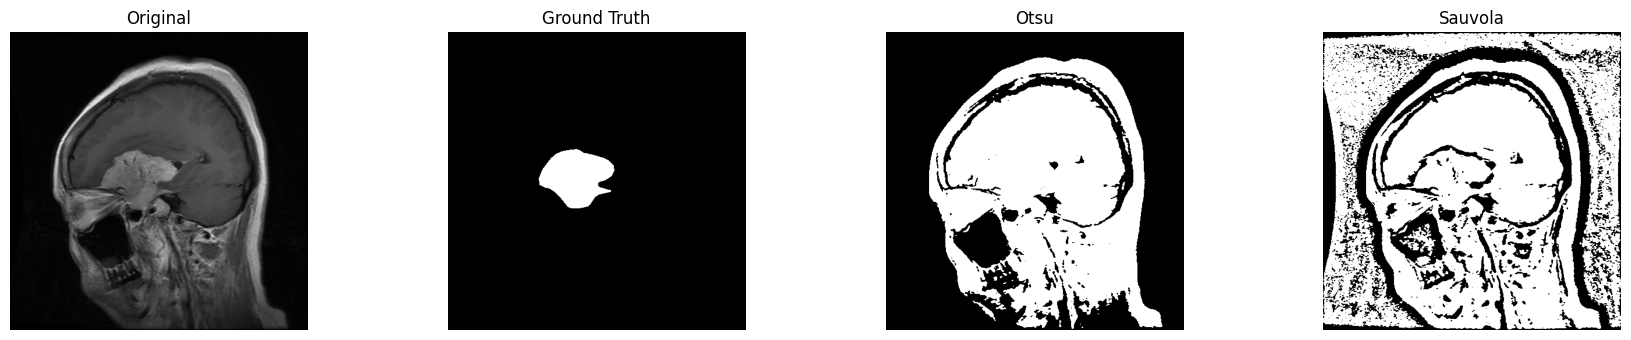

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, io as skio
from skimage.filters import threshold_otsu, threshold_sauvola

def load_gray(path: Path) -> np.ndarray:
    img = skio.imread(path)
    if img.ndim == 3:
        return color.rgb2gray(img)
    if img.dtype == np.float32:
        return img
    return img.astype(np.float32) / 255.0

def segment_otsu(gray: np.ndarray) -> np.ndarray:
    t = threshold_otsu(gray)
    return gray > t

def segment_sauvola(gray: np.ndarray, window_size: int = 31, k: float = 0.2) -> np.ndarray:
    t = threshold_sauvola(gray, window_size=window_size, k=k)
    return gray > t

if pairs:
    sample_img, sample_mask = random.choice(pairs)
    gray = load_gray(sample_img)
    gt = load_gray(sample_mask)
    mask_otsu = segment_otsu(gray)
    mask_sauvola = segment_sauvola(gray)

    fig, axes = plt.subplots(1, 4, figsize=(18, 3.5))
    axes[0].imshow(gray, cmap="gray")
    axes[0].set_title("Original")
    axes[1].imshow(gt, cmap="gray")
    axes[1].set_title("Ground Truth")
    axes[2].imshow(mask_otsu, cmap="gray")
    axes[2].set_title("Otsu")
    axes[3].imshow(mask_sauvola, cmap="gray")
    axes[3].set_title("Sauvola")
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
else:
    print("No image-mask pairs found. Check dataset or pairing logic.")

## Segmentation: Otsu vs Sauvola

## Metrics: Dice and Jaccard

In [7]:
def dice_jaccard(pred: np.ndarray, gt: np.ndarray) -> tuple[float, float]:
    pred_b = pred.astype(bool)
    gt_b = gt.astype(bool)
    inter = np.logical_and(pred_b, gt_b).sum()
    union = np.logical_or(pred_b, gt_b).sum()
    dice = (2.0 * inter) / (pred_b.sum() + gt_b.sum() + 1e-8)
    jacc = inter / (union + 1e-8)
    return float(dice), float(jacc)

if not pairs:
    print("No image-mask pairs found. Check dataset structure or is_mask_path rules.")
else:
    sample_pairs = random.sample(pairs, len(pairs))
    dice_otsu = []
    jacc_otsu = []
    dice_sauvola = []
    jacc_sauvola = []
    for img_path, mask_path in sample_pairs:
        gray = load_gray(img_path)
        gt = load_gray(mask_path) > 0.5
        pred_otsu = segment_otsu(gray)
        pred_sauvola = segment_sauvola(gray,window_size= 55, k = 0.3)
        d, j = dice_jaccard(pred_otsu, gt)
        dice_otsu.append(d)
        jacc_otsu.append(j)
        d, j = dice_jaccard(pred_sauvola, gt)
        dice_sauvola.append(d)
        jacc_sauvola.append(j)
    print("Samples with masks:", len(sample_pairs))
    print("Otsu  Dice/Jaccard:", np.mean(dice_otsu), np.mean(jacc_otsu))
    print("Sauvola Dice/Jaccard:", np.mean(dice_sauvola), np.mean(jacc_sauvola))

Samples with masks: 3064
Otsu  Dice/Jaccard: 0.07074164298403321 0.037645978968524285
Sauvola Dice/Jaccard: 0.04907834813206159 0.02560246168943964


In [11]:
import pandas as pd

# Hyperparameter tuning for Sauvola
window_sizes = [15, 25, 35, 45, 55]
k_values = [0.1, 0.15, 0.2, 0.25, 0.3]

# Validation set: sample ~10% of pairs for faster tuning
val_pairs = random.sample(pairs, min(int(len(pairs) * 0.1), 500))

results = []

print("Starting Sauvola hyperparameter tuning...")
print(f"Validation samples: {len(val_pairs)}\n")

for window_size in window_sizes:
    for k in k_values:
        if window_size % 2 == 0:
            window_size += 1  
        
        dice_scores = []
        jacc_scores = []
        
        for img_path, mask_path in val_pairs:
            gray = load_gray(img_path)
            gt = load_gray(mask_path) > 0.5
            pred = segment_sauvola(gray, window_size=window_size, k=k)
            d, j = dice_jaccard(pred, gt)
            dice_scores.append(d)
            jacc_scores.append(j)
        
        mean_dice = np.mean(dice_scores)
        mean_jacc = np.mean(jacc_scores)
        
        results.append({
            'window_size': window_size,
            'k': k,
            'mean_dice': mean_dice,
            'mean_jaccard': mean_jacc
        })
        
        print(f"window_size={window_size:2d}, k={k:.2f} | Dice: {mean_dice:.4f}, Jaccard: {mean_jacc:.4f}")

results_df = pd.DataFrame(results)
best_idx = results_df['mean_dice'].idxmax()
best_params = results_df.loc[best_idx]

print("\n" + "="*60)
print("BEST PARAMETERS (by Dice score):")
print("="*60)
print(f"window_size: {int(best_params['window_size'])}")
print(f"k: {best_params['k']:.2f}")
print(f"Mean Dice: {best_params['mean_dice']:.4f}")
print(f"Mean Jaccard: {best_params['mean_jaccard']:.4f}")
print("="*60)

Starting Sauvola hyperparameter tuning...
Validation samples: 306

window_size=15, k=0.10 | Dice: 0.0461, Jaccard: 0.0240
window_size=15, k=0.15 | Dice: 0.0460, Jaccard: 0.0239
window_size=15, k=0.20 | Dice: 0.0455, Jaccard: 0.0236
window_size=15, k=0.25 | Dice: 0.0448, Jaccard: 0.0233
window_size=15, k=0.30 | Dice: 0.0442, Jaccard: 0.0230
window_size=25, k=0.10 | Dice: 0.0456, Jaccard: 0.0237
window_size=25, k=0.15 | Dice: 0.0461, Jaccard: 0.0239
window_size=25, k=0.20 | Dice: 0.0460, Jaccard: 0.0239
window_size=25, k=0.25 | Dice: 0.0457, Jaccard: 0.0238
window_size=25, k=0.30 | Dice: 0.0454, Jaccard: 0.0236
window_size=35, k=0.10 | Dice: 0.0456, Jaccard: 0.0237
window_size=35, k=0.15 | Dice: 0.0463, Jaccard: 0.0240
window_size=35, k=0.20 | Dice: 0.0465, Jaccard: 0.0242
window_size=35, k=0.25 | Dice: 0.0466, Jaccard: 0.0242
window_size=35, k=0.30 | Dice: 0.0465, Jaccard: 0.0242
window_size=45, k=0.10 | Dice: 0.0461, Jaccard: 0.0239
window_size=45, k=0.15 | Dice: 0.0467, Jaccard: 0.024

### Results and Learnings
- On 3,064 paired samples, Otsu beats Sauvola here (Dice 0.0707 vs 0.0491; Jaccard 0.0376 vs 0.0256).
- The Sauvola sweep improves only slightly; best is window_size=55, k=0.30 with Dice 0.0485 and Jaccard 0.0253.
- Overall Dice/Jaccard are low for both, suggesting simple thresholding struggles with this dataset; more advanced methods or preprocessing would likely be needed.